In [1]:
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from copy import deepcopy

In [2]:
def accept_matrix(deltaFitness, temp):
    return np.minimum(np.ones(deltaFitness.shape), np.exp(-(deltaFitness)/temp))
@jit
def accept(deltaFitness, temp):
    return np.random.uniform(0, 1) < min(1.0, math.exp(-(deltaFitness)/temp))
@jit
def set_initial_temperature(m1, m2, avgFitnessDiff, p0):
    return -avgFitnessDiff / math.log(p0)

def simulated_annealing_bootstrap(S_current, targetInitTemp, funcFitness, funcMove):
    from copy import deepcopy
    fitnessDiffSum = 0
    #bootstrapping 
    S = deepcopy(S_current)
    currentFitness = funcFitness(S)
    m1=m2=0
    for i in range(100):
        _S = funcMove(deepcopy(S))
        dE = funcFitness(_S) - currentFitness
        if dE <= 0: 
            m1+=1
            fitnessDiffSum += -dE
    print(fitnessDiffSum)
    return set_initial_temperature(m1, m2, fitnessDiffSum / m1, targetInitTemp)

@jit
def simulated_annealing(S_current, initAccept, funcFitness, funcMove):
    T = simulated_annealing_bootstrap(S_current, initAccept, funcFitness, funcMove)
    N = len(S_current)
    hasntImproved = 0
    bestFitness = funcFitness(S_current)
    sys.stdout.write("Temperature: %f; Current Fitness: %d\t\r"%(T,funcFitness(S_current)))
    sys.stdout.flush()
    while hasntImproved < 3:
        N_iter = 0
        N_accept = 0
        currentFitness = funcFitness(S_current)
        hasImproved = False
        while N_accept < 12*N and N_iter < 100*N:
            S_new = funcMove(S_current[:])
            newFitness = funcFitness(S_new)
            if accept(newFitness-currentFitness, T):
                S_current = S_new
                N_accept += 1
            if newFitness-currentFitness < 0:
                hasImproved = True
            N_iter += 1
        if not hasImproved:
            hasntImproved += 1
        else:
            hasntImproved = 0
                   
        T = 0.9*T
        
        sys.stdout.write("Temperature: %f;  Current Fitness: %f\t\r" % (T, funcFitness(S_current)))
        sys.stdout.flush() 
    return S_current

In [3]:
@jit
def fitness(solution, distance):
    cost = 0
    for i in range(len(solution)-1):
        cost += distance[solution[i]][solution[i+1]]
    cost += distance[solution[-1]][solution[0]]
    return cost  

def move(solution, distance):
    first, second = int(np.random.uniform(len(solution))), int(np.random.uniform(len(solution)))
    while first == second:
        second = int(np.random.uniform(len(solution)))
    solution[first], solution[second] = solution[second], solution[first]   
    return solution

@njit
def two_opt_algorithm(solution, distance):
    change = True
    while change:
        change = False
        for i, _ in enumerate(solution[:-1]):
            for j, _ in enumerate(solution[:-1]):
                if j != i-1 and j != i and j != i+1:
                    if distance[solution[i]][solution[i+1]] + distance[solution[j]][solution[j+1]] >= distance[solution[i]][solution[j]] + distance[solution[i+1]][solution[j+1]]:
                        solution[i+1], solution[j] = solution[j], solution[i+1]
                        change = True
    return solution
@jit
def two_opt_move(solution, distance):
    S = len(solution)
    i = j = np.random.randint(0, S)
    while i==j:
        j = np.random.randint(0, S)
    solution[i+1:j+1] = solution[i+1:j+1][::-1]        
    return solution

def get_travel(solution, city_points):
    travel = []
    for v in solution:
        travel.append(city_points[v])
    travel.append(city_points[solution[0]])
    return np.array(travel)

def init_tsp(NB_CITIES):
    cities = np.random.rand(NB_CITIES, 2)
    distances = np.zeros((NB_CITIES, NB_CITIES))

    for from_city, p1 in enumerate(cities):
        for to_city, p2 in enumerate(cities):
            if from_city != to_city:
                distances[from_city][to_city] = distances[to_city][from_city] = np.linalg.norm(p1-p2)
    return cities, distances

8.380679182244386
[92, 9, 38, 98, 14, 17, 24, 37, 65, 93, 5, 99, 26, 78, 3, 95, 44, 28, 61, 2, 68, 10, 48, 43, 70, 45, 20, 94, 22, 35, 84, 4, 55, 11, 71, 40, 34, 30, 27, 16, 59, 8, 69, 47, 0, 50, 62, 1, 25, 29, 90, 89, 87, 31, 23, 64, 12, 63, 83, 96, 39, 80, 91, 6, 77, 82, 79, 19, 54, 86, 13, 7, 85, 72, 74, 49, 53, 32, 58, 33, 81, 76, 42, 15, 60, 73, 51, 57, 75, 67, 66, 52, 56, 18, 21, 41, 97, 36, 46, 88]
8.309840238678268


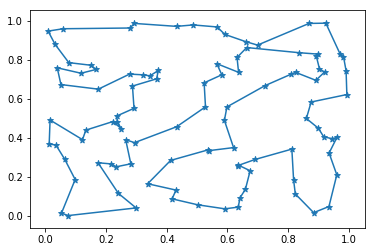

In [5]:
#%%prun -s cumulative -q -l 10 -T prun0

NB_CITIES = 100
cities, distances = init_tsp(NB_CITIES)
solution=(list(range(NB_CITIES)))
np.random.shuffle(solution)

solution = simulated_annealing(solution, 0.5, lambda solution: fitness(solution, distances), lambda solution: two_opt_move(solution, distances))

print(solution)
print(fitness(solution, distances))
x, y = zip(*get_travel(solution, deepcopy(cities)))
plt.plot(x,y)
x, y = zip(*cities)
plt.scatter(x, y, marker='*') 


In [ ]:
#print(open('prun0', 'r').read())

In [ ]:
x = [1,2,3,4]

In [ ]:
x.reverse()